Notebook color scheme


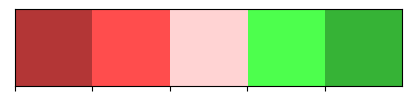

In [14]:
from typing import Union, List, Tuple, Any, Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import os
import sys
import random 
import warnings


from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import auc, precision_recall_curve, classification_report, confusion_matrix, f1_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from IPython.display import display_latex, display_markdown
from matplotlib.colors import ListedColormap

from datetime import datetime
from colorama import Fore, Style
from collections import defaultdict
from functools import partial

warnings.filterwarnings('ignore')

class clr:
    S = Style.BRIGHT + Fore.RED
    E = Style.RESET_ALL

MY_COLORS = ["#b33636", "#ff4d4d", "#ffd3d3", "#4dff4d", "#36b336"]
MY_CMAP = ListedColormap(MY_COLORS)
print(clr.S+"Notebook color scheme"+clr.E)
sns.palplot(sns.color_palette(MY_COLORS))
plt.show()

In [15]:
df = pd.read_csv("./data/clean_health - clean_health.csv")
df.head()

,papaId,createdAt,eventType,DeviceID,MessageID,Payload,path,hops,duckType,corrupted_device,corrupted_message,charging,counter,full,volts,board_temp,packet_loss,is_lost
0,OWL_HQ,2022-03-12 0:00:10,health,IRDUCK01,UV16,Counter:58 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,58,0,-3.0,-3.0,1,0
1,OWL_HQ,2022-03-12 0:01:47,health,HEALTHDK,DE1R,Counter:61 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,61,0,-3.0,-3.0,2,1
2,OWL_HQ,2022-03-12 0:02:10,health,IRDUCK01,6T9P,Counter:59 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,59,0,-3.0,-3.0,1,0
3,OWL_HQ,2022-03-12 0:03:48,health,HEALTHDK,UVR4,Counter:62 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,62,0,-3.0,-3.0,1,0
4,OWL_HQ,2022-03-12 0:05:47,health,HEALTHDK,DVI7,Counter:63 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,63,0,-3.0,-3.0,1,0


# Data Modeling

## - Data Splitting

In [16]:
df_mod = df[["DeviceID", "hops", "charging", "counter", "volts", "board_temp", "is_lost"]]

label_device = LabelEncoder()
scaler = StandardScaler()

df_mod["DeviceID"] = label_device.fit_transform(df_mod["DeviceID"])
# scaled_feat = scaler.fit_transform(df_mod[["hops", "counter", "volts", "board_temp"]])
# df_mod[["hops", "counter", "volts", "board_temp"]] = scaled_feat

df_train, df_test = train_test_split(df_mod, test_size=0.05, random_state=42, stratify=df["is_lost"])
print(clr.S+"===== Training Data Information ====="+clr.E)
print("\n\n")
display_markdown(f"Number of records : ${df_train.shape[0]}$", raw=True)
display_markdown(f"Number of attributes : ${df_train.shape[1] - 1}$", raw=True)
print("\n\n")

print(clr.S+"===== Test Data Information ====="+clr.E)
print("\n\n")
display_markdown(f"Number of records : ${df_test.shape[0]}$", raw=True)
display_markdown(f"Number of attributes : ${df_test.shape[1] - 1}$", raw=True)


scaled_feat = scaler.fit_transform(df_train[["hops", "counter", "volts", "board_temp"]])
df_train[["hops", "counter", "volts", "board_temp"]] = scaled_feat
df_test[["hops", "counter", "volts", "board_temp"]] = scaler.transform(df_test[["hops", "counter", "volts", "board_temp"]])

===== Training Data Information =====





Number of records : $87828$

Number of attributes : $6$




===== Test Data Information =====





Number of records : $4623$

Number of attributes : $6$

In [17]:
X_train, y_train = df_train.drop('is_lost', axis=1).values, df_train['is_lost'].values
X_test, y_test = df_test.drop('is_lost', axis=1).values, df_test['is_lost'].values

In [18]:
from sklearn.metrics import confusion_matrix

def confusion_display(y_true:np.ndarray, y_pred:np.ndarray) -> None:
    conf_mat = confusion_matrix(y_true, y_pred, normalize='true')
    
    grp = ["True Neg", "False Pos", "False Neg", "True Pos"]
    annot = [f"{x1}\n{np.round(x2, 2)}" for x1, x2 in zip(grp, conf_mat.flatten())]
    annot = np.array(annot).reshape(2, 2)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_title("Confusion Matrix", fontsize=16, weight="bold")
    sns.heatmap(conf_mat, annot=annot, fmt="", ax=ax,
                cmap=MY_CMAP, cbar=True, linewidths=2.0)
    ax.set_xticklabels(["No LOSS", "LOSS"])
    ax.set_yticklabels(["No LOSS", "LOSS"])
    ax.set_xlabel("Predictions")
    ax.set_ylabel("Acutal")
    plt.show()
    

In [19]:
neg, pos = np.bincount(df["is_lost"].values)
class_weight_0 = 1 - (neg / (neg + pos))
class_weight_1 = 1 - (pos/(neg + pos))

# class_wts = {0:class_weight_0, 1:class_weight_1}
class_wts = np.array([class_weight_0, class_weight_1])

## - Functions for Hyperparameter Optimization

In [20]:
def score_model(y_true:np.ndarray, y_pred:np.ndarray) -> float:
    """
    This function returns the AUC of precision-recall curve.
    
    :param y_true: the true labels.
    :param y_pred: the predicted labels.
    
    :returns: the AUC of the precision-recall curve.
    """
    
    # prec, recall, _ = precision_recall_curve(y_true, y_pred)
    # score = auc(recall, prec)
    score = f1_score(y_true, y_pred)
    
    return score
    

In [21]:
def objective(trial:optuna.Trial, data:Tuple, model_name:str, class_wts:np.ndarray=None) -> float:
    """
    The objective function to be used for optuna
    
    :param trial: the optuna trial
    :param data: the (X,y) for the model training.
    :param model_name: the name of the model
    :param class_wts: the class weights for the classes (if any)
    
    :returns: the score
    """
    
    if model_name not in ["OneClassSVM", "IF", "LOF"]:
        raise Exception(f"Expected values for model_name to be either of {'/'.join(model_name)}. Found {model_name}.")
        
    if model_name == "OneClassSVM":
        params_dist = {
            "nu" : trial.suggest_float("nu", 0.0, 1.0),
            "kernel":trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid"]),
            "gamma" : trial.suggest_categorical("gamma", ["scale", "auto"])
        }

    elif model_name == "KNN":
        params_dist = {
            "n_neighbors" : trial.suggest_int("n_neighbors", 1, 100, step=2),
            "metric" : trial.suggest_categorical("metric", ['minkowski', 'euclidean', 'cosine'])            
        }
    elif model_name == "IF":
        params_dist = {
            "n_estimators" : trial.suggest_int("n_estimators", 100, 10000, step=100),
            "contamination": trial.suggest_float("contamination", 0, 0.5)
        }
    
    models = {
        "OneClassSVM" : OneClassSVM,
        "LOF":LocalOutlierFactor,
        "IF": IsolationForest
    }
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    X, y = data
    
    val_scores = list()
    
    
    for train_idx, val_idx in kfold.split(X, y):
        
        trainX, trainy = X[train_idx], y[train_idx]
        valX, valy = X[val_idx], y[val_idx]
        
        
        sample_wt = np.where(trainy == 1, class_wts[1], class_wts[0])
        
        if model_name == "IF":
            model = models[model_name](random_state=42, n_jobs=-1, verbose=1, **params_dist)
            model.fit(trainX, sample_weight=sample_wt)
            
        elif model_name == "LOF":
            model = models[model_name](n_jobs=-1, **params_dist)
            model.fit(trainX)
        else:
            model = models[model_name](verbose=1, **params_dist)
            model.fit(trainX, sample_weight=sample_wt)
        
        val_preds = model.predict(valX)
        val_preds = np.where(val_preds == -1, 1, 0)
        val_score = score_model(valy, val_preds)
        
        val_scores.append(np.round(val_score, 4))
    
    return np.mean(val_scores)
        
    

In [22]:
def early_stop_check(study:optuna.study.Study, trial:optuna.trial.Trial, rounds:int=5) -> None:
    """
    This function acts as a early stopping criteria for optuna.
    
    :param study: the optuna study.
    :param trial: the optuna trial.
    :param rounds: number of steps to follow before early-stopping.
    
    """
    curnt_trl_num = trial.number
    bst_trl_num = study.best_trial.number
    diff = curnt_trl_num - bst_trl_num
    
    if diff >= rounds:
        print(clr.S+"Early Stopping detected !!"+clr.E)
        study.stop()

In [23]:
def repeated_cv(train:Tuple, test:Tuple, model_name:str, class_wts:np.ndarray=None, reps:int=5, early_stop_rounds:int=5) -> Dict:
    """
    This function performs the repeated cross validation of the model.
    
    :param data: the training data.
    :param test: the test data.
    :param model_name: The type of model to train. e.g. SVC for svm classifier.
    :param class_wts: the class weights for individual classes (if any)
    :param reps: number of repetetions to perform.
    :param early_stop_rounds: number of steps to check before early stopping.
    
    :returns: repeated cross validation score & best parameters.
    """
    
    models = {
        "OneClassSVM" : OneClassSVM,
        "LOF":LocalOutlierFactor,
        "IF": IsolationForest
    }
    
    details = {}
    
    for rep in range(reps):
        print(clr.S+"Repetetion - "+clr.E+str(rep + 1))
        
        sampler = optuna.samplers.TPESampler(seed=1234)
        study = optuna.create_study(
            study_name=f"repeated_cv_{model_name}_rep_{rep}" if class_wts is None else f"repeated_cv_{model_name}_classwts_rep_{rep}",
            direction="maximize",
            sampler = sampler,
            load_if_exists=True,
            storage="sqlite:///study_outlier_approach.db"
        )
        
        concat_data = np.concatenate(train, axis=1)
        np.random.shuffle(concat_data)
        X, y = concat_data[:,:-1], concat_data[:, -1].flatten() 
        func = lambda trial: objective(trial, (X, y), model_name, class_wts=class_wts)
        
        study.optimize(func,
                      n_trials=50,
                      callbacks=[partial(early_stop_check, rounds=early_stop_rounds)])
        
        print(clr.S+"Number of trials finished out of 50: "+clr.E+str(len(study.trials))+clr.S+"\n Best trial : "+clr.E+str(study.best_trial.value))
        
        best_hyp = dict()
        for k, v in study.best_trial.params.items():
            best_hyp[k] = v
        
        sample_wt = np.where(train[1].flatten() == 1, class_wts[1], class_wts[0])

        if model_name == "IF":
            model = models[model_name](random_state=42, n_jobs=-1, **best_hyp)
            model.fit(train[0], sample_weight=sample_wt)
            
        elif model_name == "LOF":
            model = models[model_name](n_jobs=-1, **best_hyp)
            model.fit(train[0])
        else:
            model = models[model_name](**best_hyp)
            model.fit(train[0], sample_weight=sample_wt)
            
        preds = np.where(model.predict(test[0]) == -1, 1, 0)
        
        score = score_model(test[1], preds)
        details[f"rep-{rep+1}"] = {"best_hyp":best_hyp, "score":score}
    
    return details
        

## - Isolation Forest

In [24]:
isof_details = repeated_cv((X_train, y_train.reshape(-1, 1)), 
                          (X_test, y_test), "IF", class_wts=class_wts, reps=10)

[I 2023-01-25 12:35:42,345] Using an existing study with name 'repeated_cv_IF_classwts_rep_0' instead of creating a new one.


Repetetion - 1


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    3.5s remaining:   17.4s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    3.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    3.3s remaining:   16.5s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    3.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    3.2s remaining:   16.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    3.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    3.6s remaining:   18.2s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    3.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 co

Early Stopping detected !!
Number of trials finished out of 50: 30
 Best trial : 0.33596


KeyboardInterrupt: 

## - OneClassSVM

In [ ]:
one_class_svm_details = repeated_cv((X_train, y_train.reshape(-1, 1)), 
                                    (X_test, y_test), "OneClassSVM", reps=10)

## - Local Outlier Factor

In [ ]:
lof_class_details = repeated_cv((X_train, y_train.reshape(-1, 1)),
                               (X_test, y_test), "LOF", reps=10)